## Super resolution train

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn
from VGGFeatureLoss import VGG16FeatureLoss

In [13]:
path = Path('test_data/brain')
path_hr = path/'HR'
path_lr = path/'LR'

In [14]:
bs,size=64,96
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [15]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [16]:
data = get_data(bs,size)

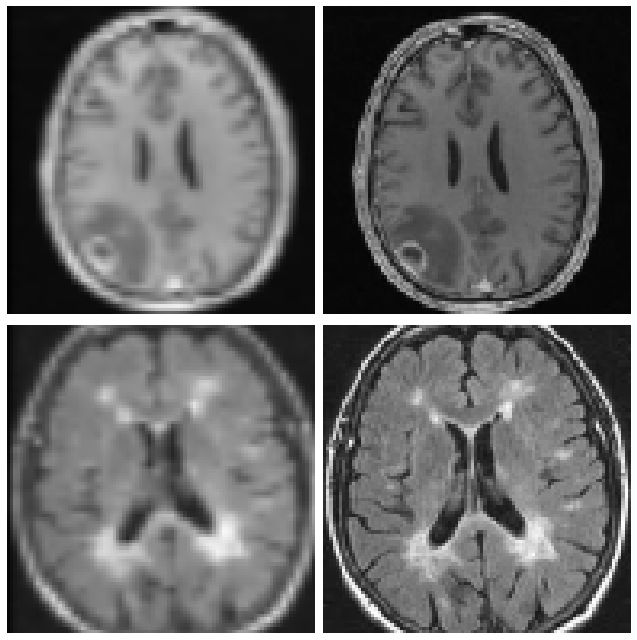

In [17]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [24]:
feat_loss = VGG16FeatureLoss([5,15,2])

## Train

In [25]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, metrics=[mean_squared_error],
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


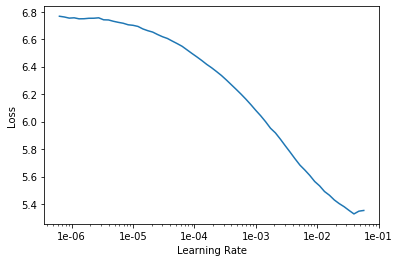

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
lr = 1e-3

In [28]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=3, imgsize=5, cmap='gray')

epoch,train_loss,valid_loss,mean_squared_error,l1_loss,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,6.309833,6.268075,1.317173,0.904699,0.384893,0.466576,0.181073,1.784539,2.304072,0.242223,00:06
1,6.071980,5.544203,0.513437,0.546464,0.351280,0.437868,0.182163,1.572533,2.185097,0.268799,00:04
2,5.827417,5.137148,0.353693,0.426291,0.326723,0.420665,0.171442,1.370285,2.109972,0.311770,00:04
3,5.532513,4.281759,0.433000,0.466680,0.287419,0.368600,0.116268,1.027397,1.852723,0.162673,00:04
4,5.232203,3.991921,0.417678,0.446568,0.271701,0.339731,0.109342,0.929448,1.742652,0.152480,00:04
5,5.000369,3.826962,0.365325,0.445897,0.261019,0.330582,0.101692,0.883161,1.668219,0.136394,00:04
6,4.812347,3.891433,0.394492,0.467413,0.256751,0.329256,0.106719,0.872758,1.707104,0.151431,00:04
7,4.664188,3.624441,0.314580,0.380654,0.245974,0.314399,0.102497,0.806282,1.630530,0.144106,00:04
8,4.550703,3.505265,0.319385,0.404306,0.240369,0.302672,0.093444,0.784856,1.548660,0.130959,00:04
9,4.433630,3.320181,0.345400,0.392949,0.230377,0.290181,0.094568,0.728519,1.448854,0.134734,00:04


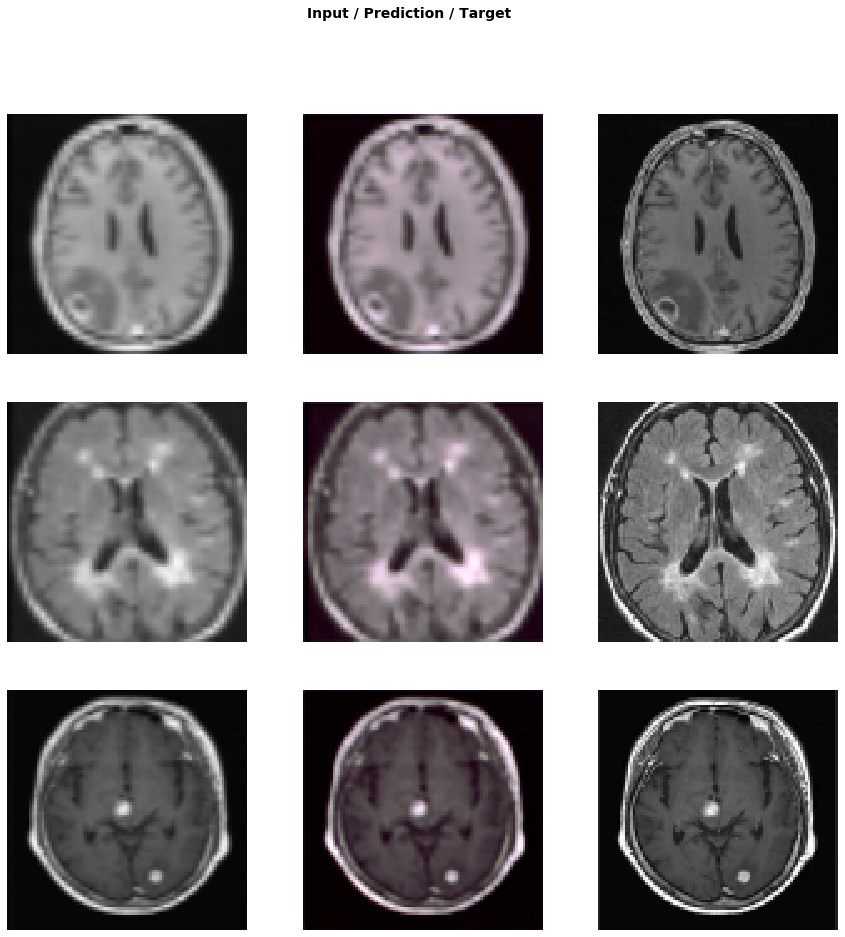

In [29]:
do_fit('1a', slice(lr*10))

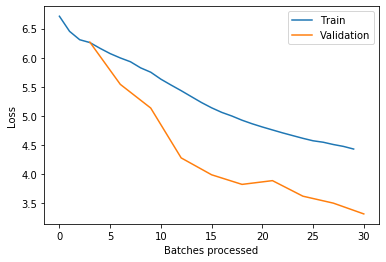

In [30]:
learn.recorder.plot_losses()
plt.savefig('losses.png')

In [31]:
learn.unfreeze()

epoch,train_loss,valid_loss,mean_squared_error,l1_loss,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.442353,3.246984,0.332313,0.379926,0.227283,0.285699,0.093264,0.709330,1.418413,0.133069,00:04
1,3.391584,3.110120,0.312942,0.357691,0.221916,0.277344,0.090736,0.673327,1.359171,0.129935,00:04
2,3.336385,2.941545,0.293113,0.328906,0.215597,0.268960,0.088707,0.621017,1.289521,0.128837,00:04
3,3.290321,2.892300,0.279933,0.324990,0.214890,0.265484,0.087242,0.616533,1.256180,0.126981,00:04
4,3.243890,2.778468,0.265734,0.316428,0.208182,0.255502,0.085256,0.594488,1.193823,0.124790,00:04
5,3.205435,2.695938,0.258656,0.318564,0.206401,0.250519,0.082872,0.575020,1.141586,0.120975,00:04
6,3.177203,2.633614,0.259242,0.315814,0.202942,0.244812,0.081003,0.559870,1.111002,0.118172,00:04
7,3.140182,2.611439,0.263742,0.315321,0.200307,0.243298,0.081201,0.545578,1.107014,0.118720,00:04
8,3.111089,2.591640,0.262870,0.315099,0.198696,0.241425,0.080724,0.542889,1.095316,0.117491,00:04
9,3.084263,2.558740,0.263679,0.319380,0.196822,0.238776,0.080775,0.530620,1.073896,0.118471,00:04


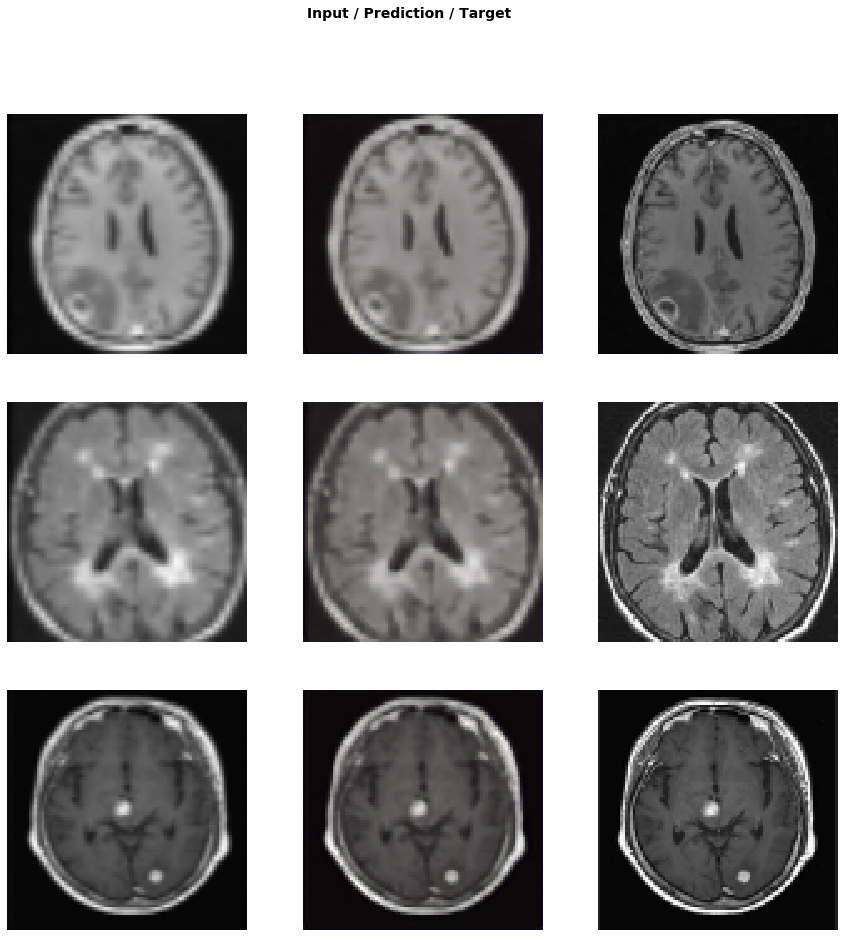

In [32]:
do_fit('1b', slice(1e-4,lr))

In [33]:
data = get_data(16,size*2)

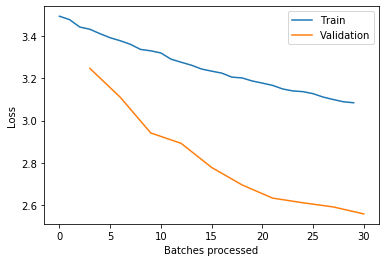

In [34]:
learn.recorder.plot_losses()

In [35]:
learn.data = data
learn.freeze()
gc.collect()

2754

In [37]:
learn.load('1b');

epoch,train_loss,valid_loss,mean_squared_error,l1_loss,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.343424,2.220582,0.285505,0.324815,0.221988,0.270431,0.111861,0.439699,0.692427,0.159360,00:24
1,2.320829,2.193253,0.289111,0.325171,0.220554,0.267431,0.111219,0.433154,0.677546,0.158177,00:11
2,2.299590,2.153023,0.286743,0.323844,0.219477,0.264994,0.110324,0.422075,0.656658,0.155650,00:12
3,2.283312,2.140957,0.286527,0.324749,0.219489,0.264739,0.109172,0.416171,0.654489,0.152148,00:11
4,2.271043,2.128376,0.286134,0.327680,0.220526,0.264052,0.107475,0.410340,0.650203,0.148101,00:11
5,2.250888,2.082033,0.294347,0.331044,0.221784,0.261622,0.105489,0.391958,0.626212,0.143925,00:12
6,2.231084,2.093295,0.282346,0.325735,0.223200,0.266913,0.104569,0.383034,0.648127,0.141717,00:12
7,2.214858,2.079198,0.292496,0.337414,0.221945,0.259346,0.101217,0.383700,0.639936,0.135640,00:12
8,2.199685,2.033995,0.292266,0.331732,0.221312,0.258168,0.101567,0.369612,0.615114,0.136491,00:12
9,2.172943,1.989121,0.294938,0.325757,0.218845,0.254215,0.100737,0.357131,0.596043,0.136393,00:12


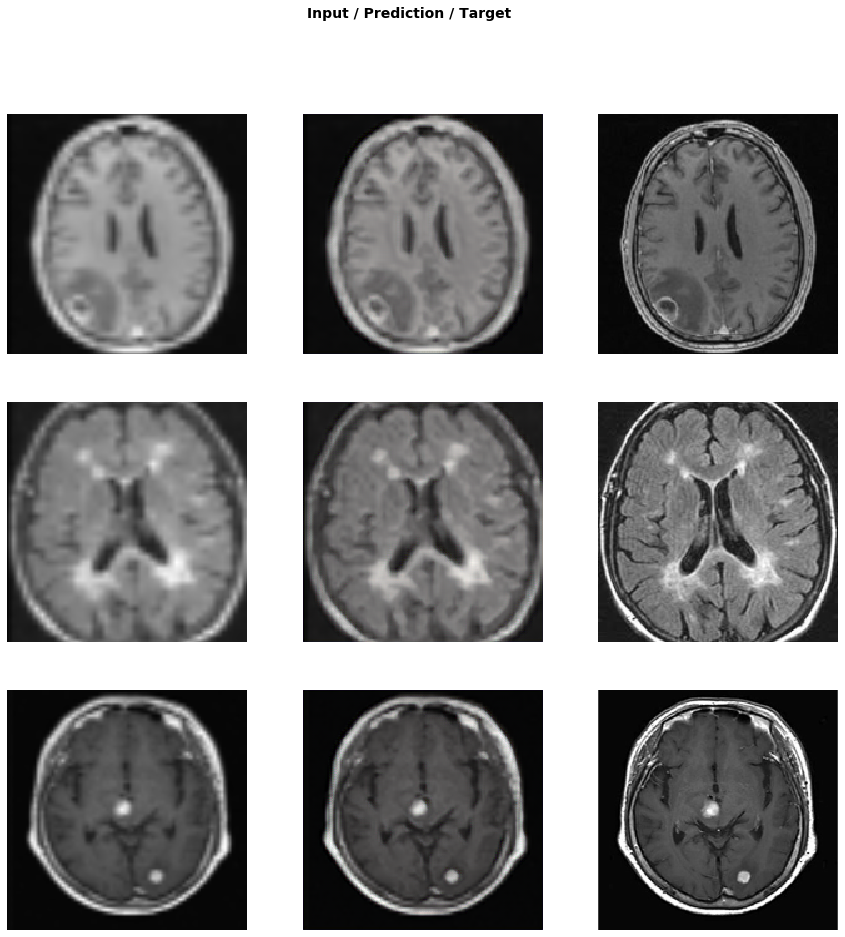

In [38]:
do_fit('2a')

In [39]:
learn.load('2a');

In [40]:
learn.unfreeze()

epoch,train_loss,valid_loss,mean_squared_error,l1_loss,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.089807,1.978253,0.295939,0.325524,0.218361,0.252741,0.100559,0.355024,0.590061,0.135984,00:13
1,2.093595,1.976507,0.290973,0.326093,0.219415,0.253445,0.099986,0.348686,0.593812,0.135070,00:12
2,2.101473,2.051561,0.298622,0.335164,0.223824,0.258834,0.100591,0.363242,0.634299,0.135607,00:12
3,2.095630,1.992937,0.290315,0.328167,0.217820,0.252804,0.099389,0.358936,0.600525,0.135297,00:12
4,2.085660,1.999914,0.301441,0.336205,0.221079,0.254970,0.099896,0.348671,0.604425,0.134669,00:13
5,2.086001,1.965985,0.298156,0.328778,0.216955,0.250472,0.099641,0.346623,0.587647,0.135868,00:12
6,2.071680,1.946093,0.299830,0.328016,0.217975,0.250311,0.099011,0.333383,0.584048,0.133349,00:12
7,2.065427,1.938524,0.301750,0.327618,0.217704,0.249159,0.098219,0.333319,0.579731,0.132773,00:12
8,2.057923,1.937188,0.303773,0.327135,0.217092,0.248962,0.098065,0.333641,0.579694,0.132601,00:12
9,2.049682,1.933025,0.303852,0.326969,0.217203,0.249006,0.097923,0.331800,0.577713,0.132412,00:13


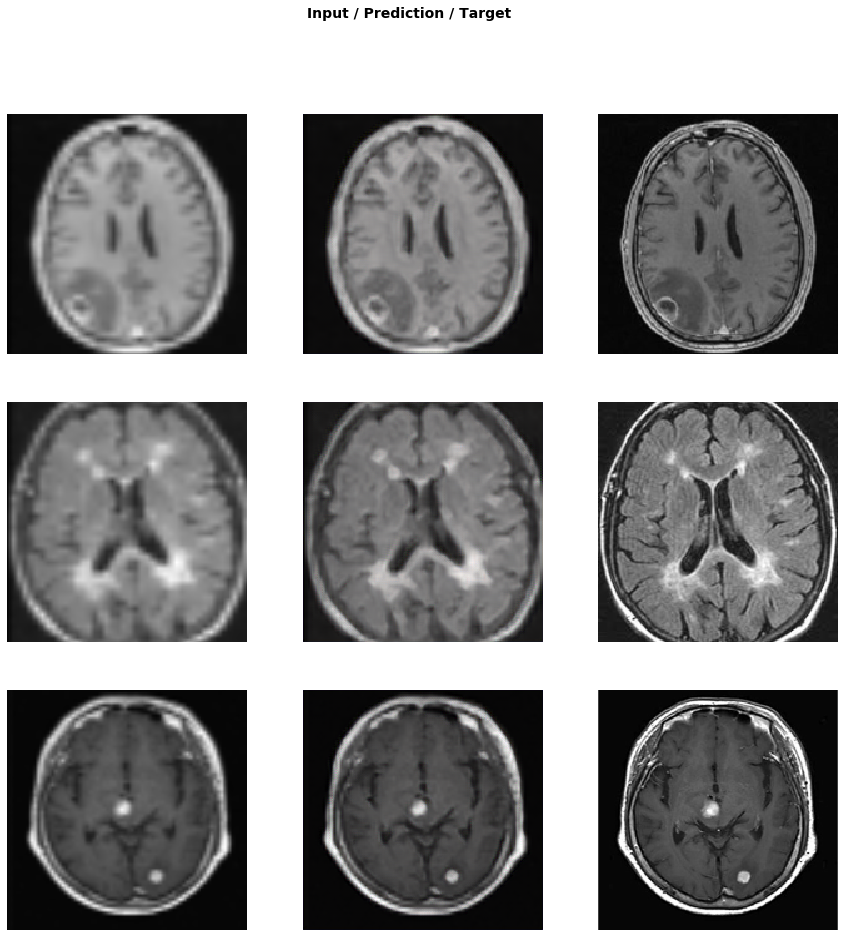

In [41]:
do_fit('2b', slice(1e-5,1e-3), pct_start=0.3)

## Test

In [42]:
learn = None
gc.collect();

In [51]:
size=(280,230)

In [52]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [53]:
data = (ImageImageList.from_folder(path/'LR').split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path/'HR'/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=5).normalize(imagenet_stats, do_y=True))
data.c = 3

In [54]:
learn.load('2b');

In [55]:
learn.data = data

In [67]:
fn_lr = data.valid_ds.x.items[0]; fn_lr
fn_hr = data.valid_ds.y.items[0]; fn_hr

PosixPath('test_data/brain/HR/N19.png')

In [68]:
img_lr = open_image(fn_lr); img.shape
img_hr = open_image(fn_hr); img.shape

torch.Size([3, 57, 46])

In [64]:
p,img_pr,b = learn.predict(img)

In [69]:
img_hr.shape

torch.Size([3, 282, 230])

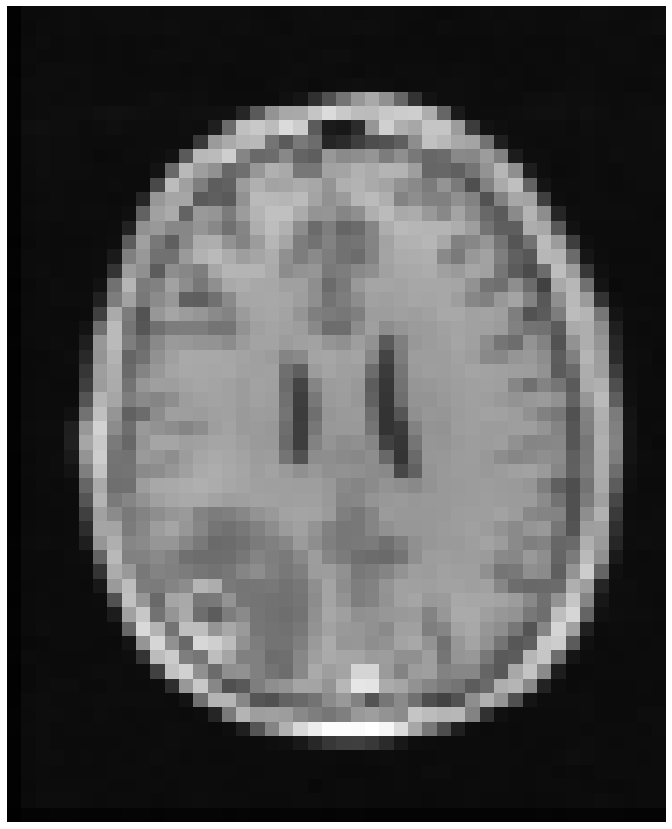

In [60]:
show_image(img_lr, figsize=(15,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


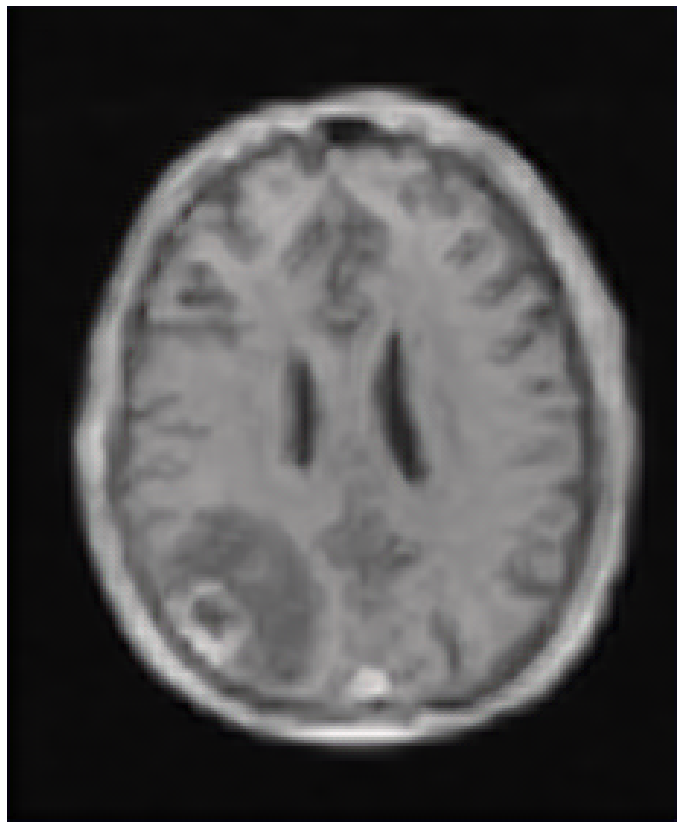

In [72]:
Image(img_pr).show(figsize=(15,15))

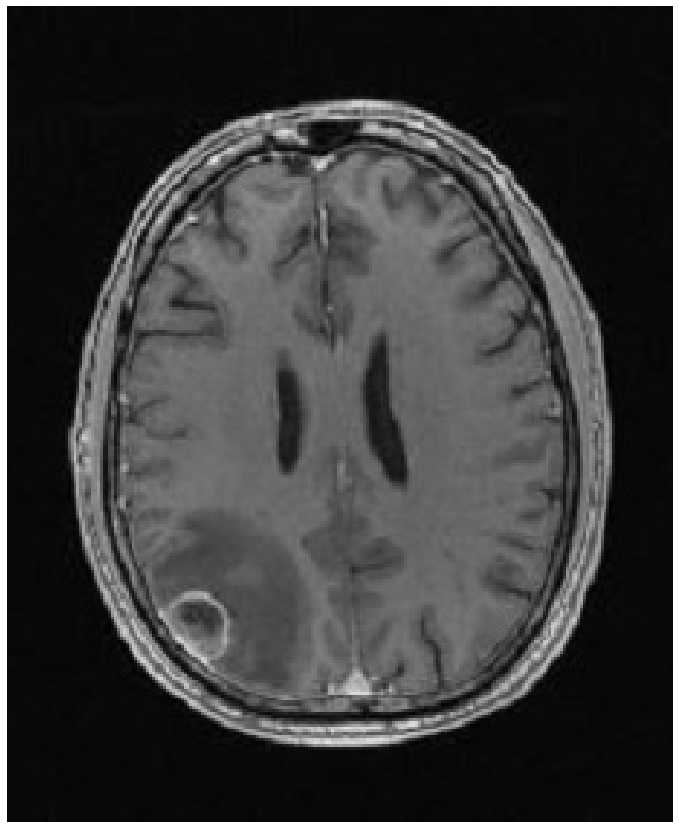

In [70]:
show_image(img_hr, figsize=(15,15), interpolation='nearest');

In [97]:
os.path.basename(fn).replace('png', 'csv')

'basset_hound_9.csv'

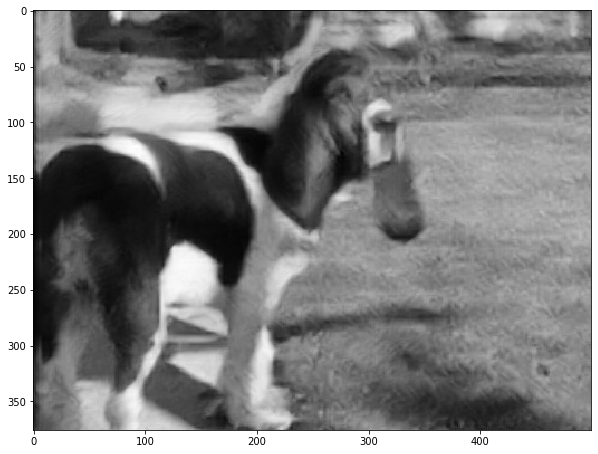

In [98]:
fig, ax = plt.subplots(figsize=(10,10))
arr = np.squeeze((img_hr[0]+img_hr[1]+img_hr[2])/3) # you can give axis attribute if you wanna squeeze in specific dimension
#im = PIL.Image.fromarray(np.uint8((arr)*255))
ax.imshow(arr, cmap='gray')
#ax.plot(arr[:,75])
np.savetxt(os.path.basename(fn).replace('png', 'csv'), arr, delimiter=",")

In [55]:
Image(img_hr).save(str('./RES'+fn.name.strip('.png')+'HR.png'))

In [56]:
img_hr

tensor([[[0.2729, 0.2264, 0.2132,  ..., 0.6685, 0.6732, 0.6433],
         [0.2209, 0.1976, 0.2111,  ..., 0.5295, 0.4802, 0.4956],
         [0.2327, 0.2262, 0.2113,  ..., 0.5032, 0.4960, 0.5103],
         ...,
         [0.7751, 0.7229, 0.7762,  ..., 0.7693, 0.7668, 0.7254],
         [0.7698, 0.7351, 0.7640,  ..., 0.7453, 0.7563, 0.7389],
         [0.7180, 0.7018, 0.7282,  ..., 0.7186, 0.6984, 0.6986]],

        [[0.2812, 0.2282, 0.2217,  ..., 0.6743, 0.6854, 0.6488],
         [0.2299, 0.2034, 0.2126,  ..., 0.5318, 0.4831, 0.4989],
         [0.2471, 0.2284, 0.2161,  ..., 0.5090, 0.4928, 0.5065],
         ...,
         [0.7976, 0.7504, 0.7771,  ..., 0.7734, 0.7770, 0.7111],
         [0.7857, 0.7342, 0.7666,  ..., 0.7476, 0.7558, 0.7382],
         [0.7323, 0.7120, 0.7321,  ..., 0.7184, 0.7017, 0.7020]],

        [[0.2752, 0.2221, 0.2119,  ..., 0.6592, 0.6671, 0.6362],
         [0.2262, 0.1982, 0.2085,  ..., 0.5279, 0.5010, 0.4848],
         [0.2405, 0.2306, 0.2145,  ..., 0.5108, 0.4917, 0.

In [53]:
str(fn.name.strip('.png')+'HR.png')

'C10_BS5_RR50_0011HR.png'

In [56]:
for fn in data.valid_ds.x.items:
    fn
    img = open_image(fn)
    p,img_hr,b = learn.predict(img)

    # im = transforms.ToPILImage()(img_hr).convert("L")
    # im.save(str('./RES/'+fn.name.strip('.png')+'HR.png'))
    
    savename = path/'RES3'/str(fn.name.strip('.png')+".csv")
    arr = np.squeeze((img_hr[0]+img_hr[1]+img_hr[2])/3)
    np.savetxt(savename, arr, delimiter=",")

In [186]:
from torchvision import transforms

In [190]:
im.show()

In [48]:
learn.show_results(rows=10, imgsize=3, cmap='gray')

RuntimeError: CUDA out of memory. Tried to allocate 1.85 GiB (GPU 0; 8.00 GiB total capacity; 4.57 GiB already allocated; 1.20 GiB free; 460.57 MiB cached)

In [99]:
learn.show_results??

In [185]:
learn = None
gc.collect();

In [71]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370)
y: ImageList
Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370)
Path: C:\Users\Admin\.fastai\data\ablation\PetsLR;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370)
y: ImageList
Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370),Image (3, 400, 370)
Path: C:\Users\Admin\.fastai\data\ablation\PetsLR;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_s